In [16]:
import numpy as np
import pandas as pd
import monai
import torch
import dlib
import mediapipe as mp
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import csv
from math import atan2, degrees

from torch.utils.data import Dataset


Testing scraper results

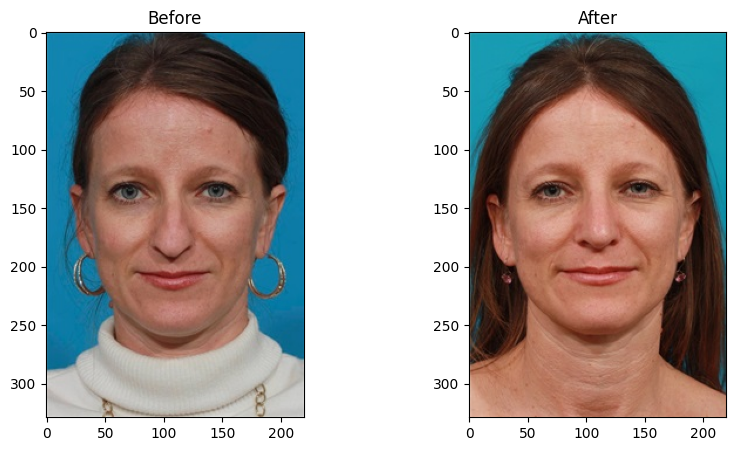

In [17]:
before_img = Image.open('../data_mining/rhinoplasty_images/before-1.jpg')
after_img = Image.open('../data_mining/rhinoplasty_images/after-1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(before_img)
axes[0].set_title('Before')
axes[1].imshow(after_img)
axes[1].set_title('After')
plt.show()

## Image Processing and Analysis for Rhinoplasty

In this section, we perform image processing and analysis on before-and-after images of rhinoplasty procedures. </br>
Cela inclut: </br>

- Displaying before and after images using `matplotlib`.
- Loading and processing a CSV file containing metadata about the images.
- Defining a function to extract facial landmarks and calculate angles using `dlib`.
- Visualizing the nasolabial and nasal bridge angles on the images.
- Extracting bounding boxes and Hu moments for shape descriptors using `OpenCV`.
- Iterating over the dataset to process each image pair and save the results to a CSV file.

This analysis helps in understanding the changes in facial features post-surgery by comparing angles and shape descriptors.

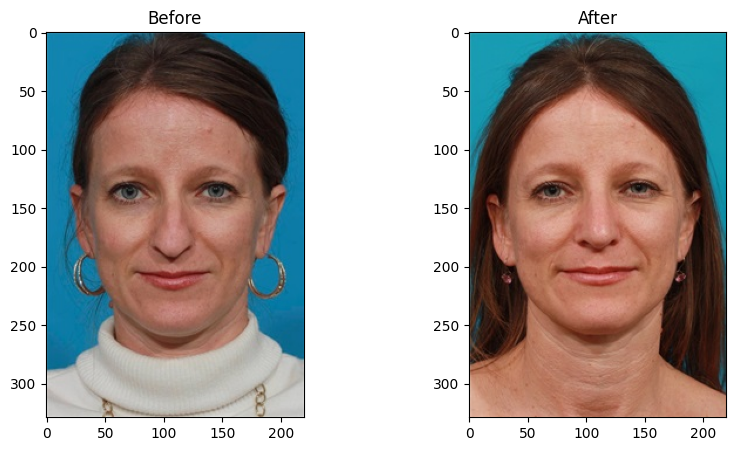

In [18]:
# Display un exemple de before and after images
before_img = Image.open('../data_mining/rhinoplasty_images/before-1.jpg')
after_img = Image.open('../data_mining/rhinoplasty_images/after-1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(before_img)
axes[0].set_title('Before')
axes[1].imshow(after_img)
axes[1].set_title('After')
plt.show()

In [ ]:
data = pd.read_csv('../data_mining/rhinoplasty_datamined.csv', encoding='ISO-8859-1')

In [19]:

#The folder where the datamined images are stored
image_folder = '../data_mining/rhinoplasty_images/'

# Function to extract bounding box and Hu moments
def process_images(before_img_path, after_img_path):
    # Load the images
    before_img = cv2.imread(before_img_path)
    after_img = cv2.imread(after_img_path)
    if before_img is None or after_img is None:
        print(f"Error loading images: {before_img_path}, {after_img_path}")
        return None, None, None, None

    # Convert images to grayscale
    before_gray = cv2.cvtColor(before_img, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(after_img, cv2.COLOR_BGR2GRAY)

    # Threshold the images (binary images for contour and Hu moments extraction)
    _, before_thresh = cv2.threshold(before_gray, 100, 255, cv2.THRESH_BINARY)
    _, after_thresh = cv2.threshold(after_gray, 100, 255, cv2.THRESH_BINARY)

    # Extract contours for both before and after images
    before_contours, _ = cv2.findContours(before_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    after_contours, _ = cv2.findContours(after_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the largest contour (likely the face/nose region)
    before_contour = max(before_contours, key=cv2.contourArea) if before_contours else None
    after_contour = max(after_contours, key=cv2.contourArea) if after_contours else None

    # Calculate Hu moments for shape descriptors
    before_hu_moments = cv2.HuMoments(cv2.moments(before_contour)).flatten() if before_contour is not None else None
    after_hu_moments = cv2.HuMoments(cv2.moments(after_contour)).flatten() if after_contour is not None else None

    # Get bounding box for the largest contour
    if before_contour is not None:
        x, y, w, h = cv2.boundingRect(before_contour)
        before_bounding_box = (x, y, w, h)
    else:
        before_bounding_box = None

    if after_contour is not None:
        x, y, w, h = cv2.boundingRect(after_contour)
        after_bounding_box = (x, y, w, h)
    else:
        after_bounding_box = None

    return before_hu_moments, after_hu_moments, before_bounding_box, after_bounding_box

In [ ]:
# Define the folder where the images are stored
image_folder = '../data_mining/rhinoplasty_images/'

# Function to visualize images with bounding boxes and Hu moments
def visualize_images(before_img_path, after_img_path, before_hu_moments, after_hu_moments, before_bbox, after_bbox):
    # Load the images
    before_img = Image.open(before_img_path)
    after_img = Image.open(after_img_path)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the before image
    axes[0].imshow(before_img)
    axes[0].set_title('Before')
    if before_bbox:
        x, y, w, h = before_bbox
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
    axes[0].text(0, -10, f'Hu Moments: {before_hu_moments}', fontsize=8, color='red')

    # Display the after image
    axes[1].imshow(after_img)
    axes[1].set_title('After')
    if after_bbox:
        x, y, w, h = after_bbox
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[1].add_patch(rect)
    axes[1].text(0, -10, f'Hu Moments: {after_hu_moments}', fontsize=8, color='red')

    plt.show()

# # Iterate over the dataset and visualize each image pair
# for index, row in data.iterrows():
#     before_img_path = os.path.join(image_folder, f"{row['PictureOfBefore']}")
#     after_img_path = os.path.join(image_folder, f"{row['PictureOfAfter']}")
#     before_hu_moments, after_hu_moments, before_bbox, after_bbox = process_images(before_img_path, after_img_path)
#     print(f"Processing {row['PictureOfBefore']} and {row['PictureOfAfter']}")
#     visualize_images(before_img_path, after_img_path, before_hu_moments, after_hu_moments, before_bbox, after_bbox)

## Mediapipe Face Mesh Initialization

In this section, we initialize the Mediapipe Face Mesh detector, which is a powerful tool for facial landmark detection. The code performs the following:

- **Importing Mediapipe's Face Mesh Module:** The `mp.solutions.face_mesh` module is imported, which provides the functionality to detect and track facial landmarks.

- **Initializing the Face Mesh Detector:** The `FaceMesh` class is instantiated with `static_image_mode=True`. This configuration is used for processing static images, where the face mesh detector will attempt to detect facial landmarks on each image independently.

The Mediapipe Face Mesh detector is capable of identifying 468 3D facial landmarks, which can be used for various applications such as facial recognition, emotion detection, and augmented reality.

In [20]:
# Initialize Mediapipe face mesh detector
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

In [21]:

# Function to detect and crop the nose region
def extract_nose_region(image_path, margin=10):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    # Convert the image to RGB (Mediapipe expects RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform face landmark detection
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        print(f"No face landmarks detected in {image_path}")
        return None

    # Get the first detected face landmarks
    face_landmarks = results.multi_face_landmarks[0]

    # Extract nose landmarks (indices 1-5, 197-199 correspond to nose tip area)
    nose_landmarks = [face_landmarks.landmark[i] for i in [1, 2, 3, 4, 5, 197, 198, 199]]

    # Convert normalized landmarks to pixel coordinates
    h, w, _ = image.shape
    nose_points = [(int(landmark.x * w), int(landmark.y * h)) for landmark in nose_landmarks]

    # Create a bounding box around the nose
    x_coords = [point[0] for point in nose_points]
    y_coords = [point[1] for point in nose_points]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Add margin to the bounding box
    x_min = max(x_min - margin, 0)
    x_max = min(x_max + margin, w)
    y_min = max(y_min - margin, 0)
    y_max = min(y_max + margin, h)

    # Crop the nose region
    nose_region = image[y_min:y_max, x_min:x_max]

    return nose_region


In [22]:
def visualize_nose(before_img_path, after_img_path):
    before_nose = extract_nose_region(before_img_path)
    after_nose = extract_nose_region(after_img_path)

    if before_nose is None or after_nose is None:
        print(f"Could not extract nose region from one or both images: {before_img_path}, {after_img_path}")
        return

    # Display the before and after nose regions
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(cv2.cvtColor(before_nose, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Before - Nose Region')
    axes[1].imshow(cv2.cvtColor(after_nose, cv2.COLOR_BGR2RGB))
    axes[1].set_title('After - Nose Region')
    plt.show()

Visualizing nose region for image pair 1


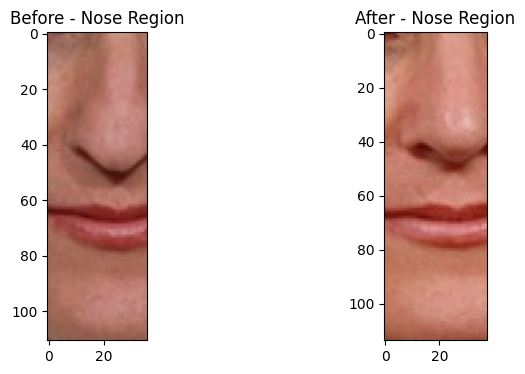

Visualizing nose region for image pair 2


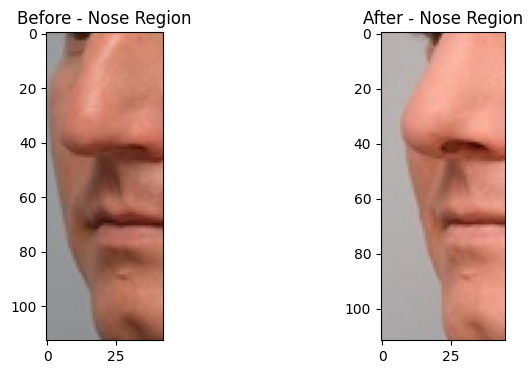

Visualizing nose region for image pair 3
No face landmarks detected in ../data_mining/rhinoplasty_images/before-3.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-3.jpg
Could not extract nose region from one or both images: ../data_mining/rhinoplasty_images/before-3.jpg, ../data_mining/rhinoplasty_images/after-3.jpg
Visualizing nose region for image pair 4


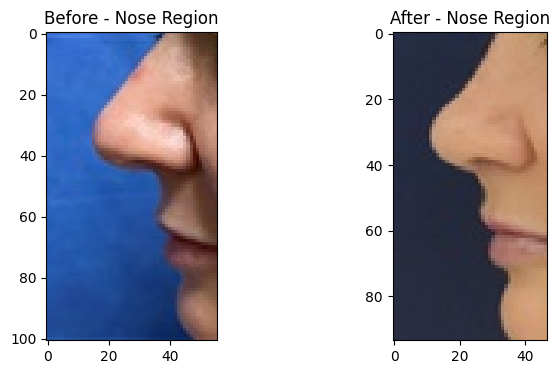

Visualizing nose region for image pair 5
No face landmarks detected in ../data_mining/rhinoplasty_images/before-5.jpg
Could not extract nose region from one or both images: ../data_mining/rhinoplasty_images/before-5.jpg, ../data_mining/rhinoplasty_images/after-5.jpg
Visualizing nose region for image pair 6
No face landmarks detected in ../data_mining/rhinoplasty_images/after-6.jpg
Could not extract nose region from one or both images: ../data_mining/rhinoplasty_images/before-6.jpg, ../data_mining/rhinoplasty_images/after-6.jpg
Visualizing nose region for image pair 7


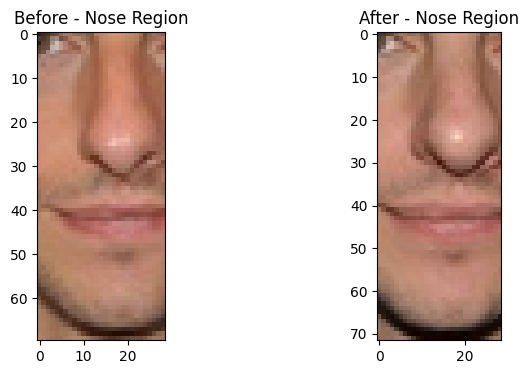

Visualizing nose region for image pair 8


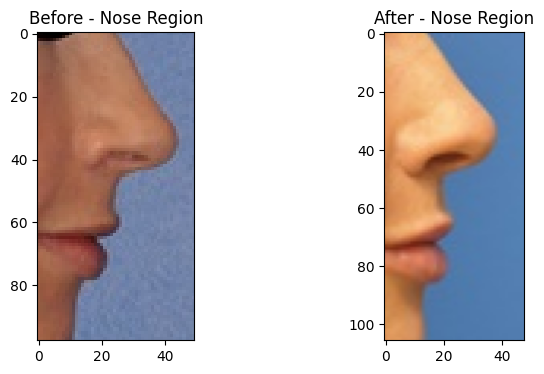

Visualizing nose region for image pair 9
No face landmarks detected in ../data_mining/rhinoplasty_images/before-9.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-9.jpg
Could not extract nose region from one or both images: ../data_mining/rhinoplasty_images/before-9.jpg, ../data_mining/rhinoplasty_images/after-9.jpg
Visualizing nose region for image pair 10


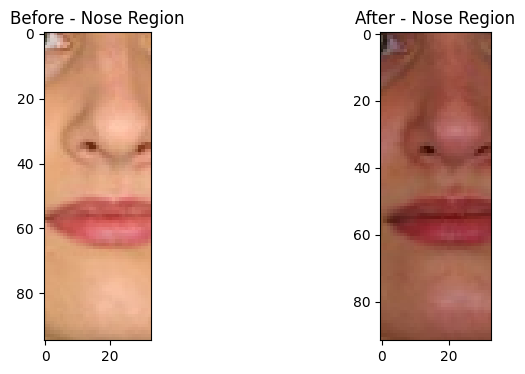

Visualizing nose region for image pair 11
No face landmarks detected in ../data_mining/rhinoplasty_images/before-11.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-11.jpg
Could not extract nose region from one or both images: ../data_mining/rhinoplasty_images/before-11.jpg, ../data_mining/rhinoplasty_images/after-11.jpg
Visualizing nose region for image pair 12


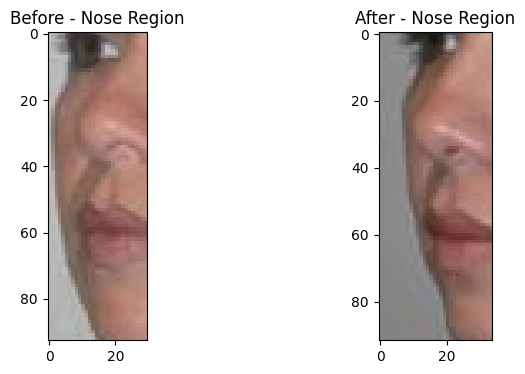

Visualizing nose region for image pair 13
No face landmarks detected in ../data_mining/rhinoplasty_images/before-13.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-13.jpg
Could not extract nose region from one or both images: ../data_mining/rhinoplasty_images/before-13.jpg, ../data_mining/rhinoplasty_images/after-13.jpg
Visualizing nose region for image pair 14


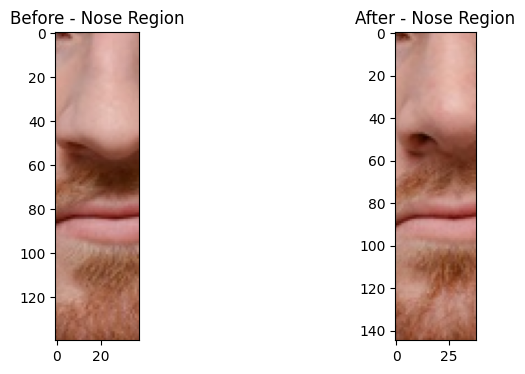

In [24]:
for i in range(1, 15):
    before_img_path = f"../data_mining/rhinoplasty_images/before-{i}.jpg"
    after_img_path = f"../data_mining/rhinoplasty_images/after-{i}.jpg"
    print(f"Visualizing nose region for image pair {i}")
    visualize_nose(before_img_path, after_img_path)

In [2]:
def save_nose_data_to_csv(image_pairs, csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image Pair", "Before Nose Bounding Box", "After Nose Bounding Box"])

        for i, (before_img_path, after_img_path) in enumerate(image_pairs, start=1):
            before_nose = extract_nose_region(before_img_path)
            after_nose = extract_nose_region(after_img_path)

            if before_nose is not None and after_nose is not None:
                # Assuming you want to save the bounding box coordinates
                before_bbox = (0, 0, before_nose.shape[1], before_nose.shape[0])
                after_bbox = (0, 0, after_nose.shape[1], after_nose.shape[0])
                writer.writerow([f"Pair {i}", before_bbox, after_bbox])
            else:
                writer.writerow([f"Pair {i}", "N/A", "N/A"])

In [7]:
image_pairs = [(f"../data_mining/rhinoplasty_images/before-{i}.jpg", f"../data_mining/rhinoplasty_images/after-{i}.jpg") for i in range(1, 902)]
save_nose_data_to_csv(image_pairs, "nose_bounding_boxes.csv")

C:\Users\fawzi\AppData\Roaming\Python\Python312\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


No face landmarks detected in ../data_mining/rhinoplasty_images/before-3.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-3.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/before-5.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-6.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/before-9.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-9.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/before-11.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-11.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/before-13.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-13.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/after-19.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/before-23.jpg
No face landmarks detected in ../data_mining/rhinoplasty_images/before-24.jp

Step by step csv combination.

In [26]:
# Load the CSV files
processed_image_features = pd.read_csv('c:/Users/fawzi/OneDrive/Bureau/PersoProj/AIforFacialSurgery/data_mining/processed_image_features.csv', encoding='ISO-8859-1')
rhinoplasty_datamined = pd.read_csv('c:/Users/fawzi/OneDrive/Bureau/PersoProj/AIforFacialSurgery/data_mining/rhinoplasty_datamined.csv', encoding='ISO-8859-1')
nose_bounding_boxes = pd.read_csv('c:/Users/fawzi/OneDrive/Bureau/PersoProj/AIforFacialSurgery/notebooks/nose_bounding_boxes.csv', encoding='ISO-8859-1')

# Debug: Print columns to ensure they match
print("Columns in rhinoplasty_datamined:", rhinoplasty_datamined.columns)
print("Columns in processed_image_features:", processed_image_features.columns)
print("Columns in nose_bounding_boxes:", nose_bounding_boxes.columns)

# Merge the DataFrames on the 'before_image' and 'after_image' columns
combined_df = pd.merge(rhinoplasty_datamined, processed_image_features, left_on=['PictureOfBefore', 'PictureOfAfter'], right_on=['before_image', 'after_image'])

# Display the combined DataFrame
combined_df

Columns in rhinoplasty_datamined: Index(['PictureOfBefore', 'PictureOfAfter', 'SurgeonInfo', 'Location',
       'Description', 'CaseNumber'],
      dtype='object')
Columns in processed_image_features: Index(['before_image', 'after_image', 'before_hu_moments', 'after_hu_moments',
       'before_bounding_box', 'after_bounding_box'],
      dtype='object')
Columns in nose_bounding_boxes: Index(['Image Pair', 'Before Nose Bounding Box', 'After Nose Bounding Box'], dtype='object')


,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)"
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)"
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,"(0, 0, 220, 140)","(0, 0, 220, 140)"
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)"
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,"(0, 0, 212, 347)","(0, 0, 212, 337)"
...,...,...,...,...,...,...,...,...,...,...,...,...
897,before-898.jpg,after-898.jpg,"Timothy Rankin, MD","Greenbrae, CA",Treatment performed: Rhinoplasty\r\nDescriptio...,48912,before-898.jpg,after-898.jpg,[1.86862492e-01 2.69528601e-03 1.29247989e-03 ...,[1.85851210e-01 5.51373128e-03 7.11248433e-04 ...,"(0, 0, 182, 212)","(6, 0, 158, 212)"
898,before-899.jpg,after-899.jpg,"Rachel Ruotolo, MD","Garden City, NY",Rhinoplasty. Pre-op and 1 year post-op,37812,before-899.jpg,after-899.jpg,[ 2.33296616e-01 2.14963887e-02 3.64173476e-...,[ 2.02826418e-01 8.83091933e-03 4.26922298e-...,"(75, 0, 145, 178)","(89, 17, 131, 160)"
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,"(0, 0, 220, 268)","(0, 0, 220, 268)"
900,before-901.jpg,after-901.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-901.jpg,after-901.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,"(0, 0, 220, 206)","(63, 23, 157, 183)"


## Interpreting Nose Bounding Boxes

The `nose_bounding_boxes` data provides information about the bounding boxes around the nose region for pairs of before-and-after images. Each entry in the data corresponds to a pair of images, and the bounding boxes are represented as tuples of coordinates.

### Data Structure

- **Image Pair:** This column indicates the pair number of the before-and-after images being analyzed.

- **Before Nose Bounding Box:** This column contains the bounding box coordinates for the nose region in the "before" image. The coordinates are represented as a tuple `(x, y, width, height)`, where:
  - `x` and `y` are the top-left corner coordinates of the bounding box.
  - `width` and `height` are the dimensions of the bounding box.

- **After Nose Bounding Box:** This column contains the bounding box coordinates for the nose region in the "after" image, following the same format as the "before" bounding box.

### Interpretation

- **Bounding Box Coordinates:** The bounding box coordinates help in identifying the region of interest (nose) in the images. By comparing the dimensions and positions of the bounding boxes in the before-and-after images, one can assess changes in the nose's size and position post-surgery.

- **NaN Values:** If a bounding box is represented as `NaN`, it indicates that the nose region could not be detected in the corresponding image. This could be due to various reasons, such as poor image quality or occlusions.

- **Example Interpretation:**
  - For "Pair 1", the before nose bounding box is `(0, 0, 36, 111)`, and the after nose bounding box is `(0, 0, 38, 114)`. This suggests a slight increase in both width and height of the nose region post-surgery.
  - For "Pair 3", both bounding boxes are `NaN`, indicating that the nose region was not detected in either image.

This data is useful for analyzing the effectiveness of rhinoplasty procedures by providing a quantitative measure of changes in the nose's appearance.

In [28]:
nose_bounding_boxes

,Image Pair,Before Nose Bounding Box,After Nose Bounding Box
0,Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)"
1,Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)"
2,Pair 3,NaN,NaN
3,Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)"
4,Pair 5,NaN,NaN
...,...,...,...
896,Pair 897,"(0, 0, 37, 127)","(0, 0, 36, 128)"
897,Pair 898,NaN,NaN
898,Pair 899,"(0, 0, 35, 67)","(0, 0, 34, 65)"
899,Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)"


In [27]:
print("Columns in nose_bounding_boxes:", nose_bounding_boxes.columns)
print("Columsn in combined_df:", combined_df.columns)

Columns in nose_bounding_boxes: Index(['Image Pair', 'Before Nose Bounding Box', 'After Nose Bounding Box'], dtype='object')
Columsn in combined_df: Index(['PictureOfBefore', 'PictureOfAfter', 'SurgeonInfo', 'Location',
       'Description', 'CaseNumber', 'before_image', 'after_image',
       'before_hu_moments', 'after_hu_moments', 'before_bounding_box',
       'after_bounding_box'],
      dtype='object')


In [29]:
# Merge the combined DataFrame with nose_bounding_boxes using concat
combined_df1 = pd.concat([combined_df, nose_bounding_boxes], axis=1, join='outer')

# Display the combined DataFrame
combined_df1

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)"
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)"
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,"(0, 0, 220, 140)","(0, 0, 220, 140)",Pair 3,NaN,NaN
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)",Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)"
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,"(0, 0, 212, 347)","(0, 0, 212, 337)",Pair 5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,before-898.jpg,after-898.jpg,"Timothy Rankin, MD","Greenbrae, CA",Treatment performed: Rhinoplasty\r\nDescriptio...,48912,before-898.jpg,after-898.jpg,[1.86862492e-01 2.69528601e-03 1.29247989e-03 ...,[1.85851210e-01 5.51373128e-03 7.11248433e-04 ...,"(0, 0, 182, 212)","(6, 0, 158, 212)",Pair 898,NaN,NaN
898,before-899.jpg,after-899.jpg,"Rachel Ruotolo, MD","Garden City, NY",Rhinoplasty. Pre-op and 1 year post-op,37812,before-899.jpg,after-899.jpg,[ 2.33296616e-01 2.14963887e-02 3.64173476e-...,[ 2.02826418e-01 8.83091933e-03 4.26922298e-...,"(75, 0, 145, 178)","(89, 17, 131, 160)",Pair 899,"(0, 0, 35, 67)","(0, 0, 34, 65)"
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,"(0, 0, 220, 268)","(0, 0, 220, 268)",Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)"
900,before-901.jpg,after-901.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-901.jpg,after-901.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,"(0, 0, 220, 206)","(63, 23, 157, 183)",Pair 901,"(0, 0, 42, 91)","(0, 0, 39, 89)"


In [11]:
def export_to_csv(df, csv_filename):
    df.to_csv(f'../data/{csv_filename}', index=False)

export_to_csv(combined_df1, 'concatenated_dataframe_v2.csv')


### Let's see the results of our feature engineering

In [30]:
new_df =  pd.read_csv('c:/Users/fawzi/OneDrive/Bureau/PersoProj/AIforFacialSurgery/Data/concatenated_dataframe_v2.csv', encoding='ISO-8859-1')

new_df.head()

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)"
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)"
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,"(0, 0, 220, 140)","(0, 0, 220, 140)",Pair 3,NaN,NaN
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)",Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)"
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,"(0, 0, 212, 347)","(0, 0, 212, 337)",Pair 5,NaN,NaN


#### Doesn't look too bad, for now, let's use this as a baseline, we can after that add some assessements and evaluations to the dataset comme de la symétrie, ou on peut faire du supervised learning avec l'évaluation d'un expert-métier par ex. Bonne chirurgie, mauvaise chirurgie, bon outcome, mauvais outcome etc.. et trouver d'autres critères d'évaluation.

Ija njarbou some AI's now en // avec le feature engineering.

## Understanding Dlib's Shape Predictor

In this section, we utilize Dlib's `shape_predictor` to detect facial landmarks, which is crucial for analyzing facial features in rhinoplasty procedures.

### What is Dlib's Shape Predictor?

Dlib's `shape_predictor` is a model that detects facial landmarks on a given image. It is based on an ensemble of regression trees, which is a machine learning technique used to predict the location of facial landmarks. The model is trained on a dataset of annotated facial images, allowing it bech accurately yidentifyi key points on the face.

### Key Components

- **`shape_predictor_68_face_landmarks.dat`:** This is a model  that contains the data necessary for the shape predictor to function. It is trained to detect 68 specific facial landmarks, including points around the eyes, nose, mouth, and jawline.

- **`dlib.get_frontal_face_detector()`:** This function initializes a face detector that identifies the presence and location of faces within an image. It uses a Histogram of Oriented Gradients (HOG) and Support Vector Machine (SVM) based approach to detect faces.

- **`dlib.shape_predictor(predictor_path)`:** This function loads the shape predictor model from the specified path. It is used to predict the positions of the 68 facial landmarks on the detected face.

### Relevance to Rhinoplasty Analysis

In the context of analyzing rhinoplasty procedures, detecting facial landmarks is essential for several reasons:

1. **Facial Feature Analysis:** By identifying landmarks around the nose, eyes, and mouth, we can measure changes in facial features before and after surgery. This includes calculating angles and distances that are indicative of surgical outcomes.

2. **Symmetry Assessment:** The landmarks allow us to assess facial symmetry, which is a critical factor in evaluating the aesthetic success of rhinoplasty.

3. **Bounding Box Extraction:** The landmarks help in defining regions of interest, such as the nose, which can be used to extract bounding boxes for further analysis.

4. **Angle Measurement:** By using specific landmarks, we can calculate angles such as the nasolabial and nasal bridge angles, providing quantitative data on the changes induced by surgery.

In [31]:
predictor_path = "../dlib_assets/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

## Symmetry Score Calculation and Visualization

In this section, we focus on calculating the symmetry score of facial features using Dlib's facial landmarks. Symmetry is an important aspect of facial aesthetics, and this analysis helps in evaluating the changes in symmetry before and after rhinoplasty surgery.

### Symmetry Score Calculation

The symmetry score is calculated by measuring the distances between pairs of facial landmarks. The following pairs are used for symmetry calculation:

- **Eyes:** Landmarks 36 and 45
- **Inner Eyes:** Landmarks 39 and 42
- **Nose:** Landmarks 31 and 35
- **Mouth Corners:** Landmarks 48 and 54

The average of these distances provides a symmetry score, which can be used to assess the balance of facial features.

### Image Processing and Symmetry Calculation

1. **Image Loading and Grayscale Conversion:** The images are loaded and converted to grayscale for facial detection.

2. **Face Detection:** The Dlib face detector is used to identify faces in the images.

3. **Landmark Detection:** For each detected face, the facial landmarks are extracted using the Dlib shape predictor.

4. **Symmetry Score Calculation:** The symmetry score is calculated using the defined pairs of landmarks.

5. **Visualization:** The images are displayed with the detected landmarks to visually assess the symmetry.

### Results

The symmetry scores for the before and after images are printed, providing a quantitative measure of the changes in facial symmetry post-surgery. Additionally, the images with landmarks are displayed to visually inspect the alignment and balance of facial features.

In [32]:
# Function to calculate symmetry score
def calculate_symmetry(landmarks):
    # Define pairs of landmarks for symmetry calculation
    symmetry_pairs = [
        (36, 45),  # Eyes
        (39, 42),  # Inner eyes
        (31, 35),  # Nose
        (48, 54),  # Mouth corners
    ]
    
    symmetry_scores = []
    for (left, right) in symmetry_pairs:
        left_point = np.array([landmarks.part(left).x, landmarks.part(left).y])
        right_point = np.array([landmarks.part(right).x, landmarks.part(right).y])
        distance = np.linalg.norm(left_point - right_point)
        symmetry_scores.append(distance)
    
    return np.mean(symmetry_scores)

# Function to process images and calculate symmetry
def process_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    if len(faces) == 0:
        print(f"No face detected in {image_path}")
        return None
    
    for face in faces:
        landmarks = predictor(gray, face)
        symmetry_score = calculate_symmetry(landmarks)
        return symmetry_score

In [33]:
before_image_path = '../data_mining/rhinoplasty_images/before-1.jpg'
after_image_path = '../data_mining/rhinoplasty_images/after-1.jpg'

# Calculate symmetry scores
before_symmetry_score = process_image(before_image_path)
after_symmetry_score = process_image(after_image_path)

print(f"Before Surgery Symmetry Score: {before_symmetry_score}")
print(f"After Surgery Symmetry Score: {after_symmetry_score}")

Before Surgery Symmetry Score: 59.01028251139718
After Surgery Symmetry Score: 60.28816065724082


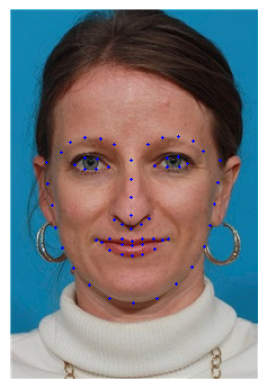

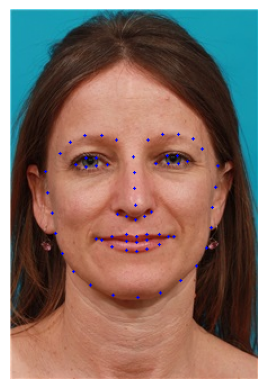

In [34]:
# Display images with landmarks
def display_image_with_landmarks(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 1, (255, 0, 0), -1)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display before and after images with landmarks
display_image_with_landmarks(before_image_path)
display_image_with_landmarks(after_image_path)

In our initial assessement with the first image, symmetry score seems to be improving after rhinoplasty.

### Let's run the face symmetry metric calculator on all the before after images and add them to our dataset as a feature

### Key Features of shape_predictor_68_face_landmarks.dat:</br>
68 Key Facial Landmarks: This model is trained to predict 68 specific points across various facial regions:</br>

Jawline: Points 1–17 </br>
Eyebrows: Points 18–27</br>
Nose: Points 28–36</br>
Eyes: Points 37–48</br>
Mouth: Points 49–68</br>
These points act as "anchors" to assess the facial structure and its alignment.

In [35]:
# Function to process all image pairs and calculate symmetry scores
def process_all_images(df, image_folder):
    before_symmetry_scores = []
    after_symmetry_scores = []
    
    for index, row in df.iterrows():
        before_image_path = os.path.join(image_folder, row['before_image'])
        after_image_path = os.path.join(image_folder, row['after_image'])
        
        before_symmetry_score = process_image(before_image_path)
        after_symmetry_score = process_image(after_image_path)
        
        if before_symmetry_score is None:
            before_symmetry_score = "FACE UNDETECTED"
        if after_symmetry_score is None:
            after_symmetry_score = "FACE UNDETECTED"
        
        before_symmetry_scores.append(before_symmetry_score)
        after_symmetry_scores.append(after_symmetry_score)
    
    df['Before_Symmetry_Score'] = before_symmetry_scores
    df['After_Symmetry_Score'] = after_symmetry_scores
    return df

# Process all images and add symmetry scores to the dataframe
image_folder = '../data_mining/rhinoplasty_images/'
new_df_with_symmetry = process_all_images(new_df, image_folder)

new_df_with_symmetry

No face detected in ../data_mining/rhinoplasty_images/before-3.jpg
No face detected in ../data_mining/rhinoplasty_images/after-3.jpg
No face detected in ../data_mining/rhinoplasty_images/before-4.jpg
No face detected in ../data_mining/rhinoplasty_images/before-5.jpg
No face detected in ../data_mining/rhinoplasty_images/after-5.jpg
No face detected in ../data_mining/rhinoplasty_images/before-6.jpg
No face detected in ../data_mining/rhinoplasty_images/after-6.jpg
No face detected in ../data_mining/rhinoplasty_images/before-8.jpg
No face detected in ../data_mining/rhinoplasty_images/before-9.jpg
No face detected in ../data_mining/rhinoplasty_images/after-9.jpg
No face detected in ../data_mining/rhinoplasty_images/before-11.jpg
No face detected in ../data_mining/rhinoplasty_images/after-11.jpg
No face detected in ../data_mining/rhinoplasty_images/before-13.jpg
No face detected in ../data_mining/rhinoplasty_images/after-13.jpg
No face detected in ../data_mining/rhinoplasty_images/before-15.

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,"(0, 0, 220, 140)","(0, 0, 220, 140)",Pair 3,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)",Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)",FACE UNDETECTED,39.606505
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,"(0, 0, 212, 347)","(0, 0, 212, 337)",Pair 5,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,before-898.jpg,after-898.jpg,"Timothy Rankin, MD","Greenbrae, CA",Treatment performed: Rhinoplasty\r\nDescriptio...,48912,before-898.jpg,after-898.jpg,[1.86862492e-01 2.69528601e-03 1.29247989e-03 ...,[1.85851210e-01 5.51373128e-03 7.11248433e-04 ...,"(0, 0, 182, 212)","(6, 0, 158, 212)",Pair 898,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED
898,before-899.jpg,after-899.jpg,"Rachel Ruotolo, MD","Garden City, NY",Rhinoplasty. Pre-op and 1 year post-op,37812,before-899.jpg,after-899.jpg,[ 2.33296616e-01 2.14963887e-02 3.64173476e-...,[ 2.02826418e-01 8.83091933e-03 4.26922298e-...,"(75, 0, 145, 178)","(89, 17, 131, 160)",Pair 899,"(0, 0, 35, 67)","(0, 0, 34, 65)",FACE UNDETECTED,FACE UNDETECTED
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,"(0, 0, 220, 268)","(0, 0, 220, 268)",Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)",55.507335,55.048443
900,before-901.jpg,after-901.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-901.jpg,after-901.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,"(0, 0, 220, 206)","(63, 23, 157, 183)",Pair 901,"(0, 0, 42, 91)","(0, 0, 39, 89)",32.82343,34.531429


There seems to be a lot of FACE UNDETECTED, let's see how much of that there is.

In [36]:
face_undetected_count = new_df_with_symmetry[new_df_with_symmetry['Before_Symmetry_Score'] == 'FACE UNDETECTED'].shape[0]
face_undetected_count

476

In [37]:
face_detected_count = new_df_with_symmetry[new_df_with_symmetry["Before_Symmetry_Score"] != "FACE UNDETECTED"].shape[0]
face_detected_count

426

In [38]:
face_undetected_count_after = new_df_with_symmetry[new_df_with_symmetry['After_Symmetry_Score'] == 'FACE UNDETECTED'].shape[0]
face_detected_count_after = new_df_with_symmetry[new_df_with_symmetry["After_Symmetry_Score"] != "FACE UNDETECTED"].shape[0]

face_undetected_count_after, face_detected_count_after


(476, 426)

In [39]:
before_undetected_after_detected_count = new_df_with_symmetry[
    (new_df_with_symmetry['Before_Symmetry_Score'] == 'FACE UNDETECTED') &
    (new_df_with_symmetry['After_Symmetry_Score'].apply(lambda x: isinstance(x, (int, float))))
].shape[0]

after_undetected_before_detected_count = new_df_with_symmetry[
    (new_df_with_symmetry['After_Symmetry_Score'] == 'FACE UNDETECTED') &
    (new_df_with_symmetry['Before_Symmetry_Score'].apply(lambda x: isinstance(x, (int, float))))
].shape[0]

print(f"Before undetected, after detected count: {before_undetected_after_detected_count}")
print(f"After undetected, before detected count: {after_undetected_before_detected_count}")

Before undetected, after detected count: 45
After undetected, before detected count: 45


In [40]:
before_undetected_after_detected_rows = new_df_with_symmetry[
    (new_df_with_symmetry['Before_Symmetry_Score'] == 'FACE UNDETECTED') &
    (new_df_with_symmetry['After_Symmetry_Score'].apply(lambda x: isinstance(x, (int, float))))
]

before_undetected_after_detected_rows

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)",Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)",FACE UNDETECTED,39.606505
7,before-8.jpg,after-8.jpg,"Adam Weinfeld, MD","Austin, TX",Rhinoplasty,44629,before-8.jpg,after-8.jpg,[ 1.77365033e-01 2.21953081e-03 1.10030853e-...,[ 1.78842601e-01 1.91760989e-03 1.95815479e-...,"(0, 0, 220, 293)","(0, 0, 220, 293)",Pair 8,"(0, 0, 50, 98)","(0, 0, 48, 106)",FACE UNDETECTED,36.625718
14,before-15.jpg,after-15.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 4 months post-op rhinoplas...",43494,before-15.jpg,after-15.jpg,[ 2.08584644e-01 1.31441424e-02 7.63205522e-...,[ 2.21718859e-01 8.08105819e-03 1.33326003e-...,"(0, 0, 220, 249)","(0, 0, 220, 249)",Pair 15,"(0, 0, 43, 106)","(0, 0, 46, 95)",FACE UNDETECTED,32.77698
35,before-36.jpg,after-36.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 30s, 3 months post-op rhinoplas...",43433,before-36.jpg,after-36.jpg,[ 2.21948921e-01 1.40353285e-02 1.87570708e-...,[ 2.22972846e-01 1.93292639e-02 1.14518372e-...,"(0, 0, 220, 279)","(27, 19, 139, 239)",Pair 36,"(0, 0, 49, 111)","(0, 0, 46, 106)",FACE UNDETECTED,44.177479
72,before-73.jpg,after-73.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, six months post-op rhinopl...",43507,before-73.jpg,after-73.jpg,[ 2.34821002e-01 9.56614788e-04 2.41804393e-...,[2.51249959e-01 2.26861469e-03 5.60888419e-03 ...,"(0, 0, 220, 257)","(0, 0, 220, 257)",Pair 73,NaN,NaN,FACE UNDETECTED,38.849649
76,before-77.jpg,after-77.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her early 20s, 2 weeks post-op rhin...",30956,before-77.jpg,after-77.jpg,[ 2.24236568e-01 4.03482343e-03 7.29354097e-...,[ 1.99107349e-01 1.16345401e-02 3.32576474e-...,"(0, 0, 220, 207)","(46, 49, 94, 158)",Pair 77,NaN,NaN,FACE UNDETECTED,24.269614
90,before-91.jpg,after-91.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 2 months post-op rhinoplas...",43539,before-91.jpg,after-91.jpg,[ 2.04303407e-01 7.69269153e-03 1.69598998e-...,[ 2.27948498e-01 2.18990270e-02 1.37567933e-...,"(0, 0, 220, 251)","(26, 36, 127, 215)",Pair 91,"(0, 0, 49, 101)","(0, 0, 47, 102)",FACE UNDETECTED,39.691551
125,before-126.jpg,after-126.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 5 months post-op rhinoplas...",35395,before-126.jpg,after-126.jpg,[ 2.76330915e-01 2.32954945e-02 3.93847066e-...,[ 1.93945987e-01 6.97661547e-03 8.46388017e-...,"(0, 0, 220, 205)","(43, 40, 155, 165)",Pair 126,"(0, 0, 37, 79)","(0, 0, 40, 77)",FACE UNDETECTED,22.511022
144,before-145.jpg,after-145.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 2 months post-op rhinoplas...",43439,before-145.jpg,after-145.jpg,[ 1.99135823e-01 2.93946196e-03 1.84918102e-...,[ 2.06940030e-01 8.00470035e-03 2.67771930e-...,"(0, 0, 220, 260)","(27, 9, 186, 251)",Pair 145,"(0, 0, 48, 105)","(0, 0, 42, 97)",FACE UNDETECTED,33.185267
147,before-148.jpg,after-148.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36254,before-148.jpg,after-148.jpg,[ 2.48735549e-01 2.18476553e-02 8.77853309e-...,[ 2.16556403e-01 1.11146203e-02 2.00473795e-...,"(0, 0, 220, 206)","(40, 29, 167, 177)",Pair 148,NaN,NaN,FACE UNDETECTED,39.182438


In [41]:
before_detected_after_undetected_rows = new_df_with_symmetry[
    (new_df_with_symmetry['After_Symmetry_Score'] == 'FACE UNDETECTED') &
    (new_df_with_symmetry['Before_Symmetry_Score'].apply(lambda x: isinstance(x, (int, float))))
]
before_detected_after_undetected_rows

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score
25,before-26.jpg,after-26.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 2 weeks post-op rhinoplast...",30894,before-26.jpg,after-26.jpg,[ 1.87649368e-01 4.24068296e-03 4.51603099e-...,[ 1.68836278e-01 1.49223831e-03 9.74682376e-...,"(0, 0, 220, 233)","(0, 0, 220, 233)",Pair 26,"(0, 0, 43, 88)","(0, 0, 34, 89)",36.003589,FACE UNDETECTED
37,before-38.jpg,after-38.jpg,"Rachel Ruotolo, MD","Garden City, NY","A woman in her 40s, with a history of congenit...",38111,before-38.jpg,after-38.jpg,[ 2.31703649e-01 1.93323172e-02 1.03701958e-...,[ 3.54115397e-01 4.80932632e-02 1.10295277e-...,"(0, 0, 220, 206)","(58, 16, 111, 190)",Pair 38,"(0, 0, 42, 96)","(0, 0, 42, 89)",33.561656,FACE UNDETECTED
57,before-58.jpg,after-58.jpg,"Adam Weinfeld, MD","Austin, TX",Rhinoplasty,44634,before-58.jpg,after-58.jpg,[0.17361111 0.00236304 0. 0. 0...,[ 1.73555875e-01 2.35867306e-03 2.28257280e-...,"(0, 0, 220, 293)","(0, 0, 220, 293)",Pair 58,NaN,NaN,37.920372,FACE UNDETECTED
196,before-197.jpg,after-197.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 30s, 4 months post-op rhinoplas...",43560,before-197.jpg,after-197.jpg,[2.11202700e-01 1.39431477e-02 7.71863661e-04 ...,[ 2.48719625e-01 2.14640335e-02 3.89493364e-...,"(0, 0, 220, 233)","(45, 29, 154, 204)",Pair 197,NaN,NaN,32.912989,FACE UNDETECTED
198,before-199.jpg,after-199.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Septorhinoplasty,44360,before-199.jpg,after-199.jpg,[ 1.80408215e-01 4.77746705e-03 9.34102227e-...,[1.81262574e-01 5.21575805e-03 1.04472402e-04 ...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 199,"(0, 0, 46, 93)","(0, 0, 44, 98)",35.81038,FACE UNDETECTED
234,before-235.jpg,after-235.jpg,"Rachel Ruotolo, MD","Garden City, NY",Rhinoplasty. Pre-op and 6 months post-op,41966,before-235.jpg,after-235.jpg,[ 2.33248953e-01 8.48496654e-03 3.58429809e-...,[2.33159235e-01 1.94974398e-02 4.44560104e-04 ...,"(58, 64, 162, 168)","(64, 55, 156, 177)",Pair 235,"(0, 0, 34, 71)","(0, 0, 36, 75)",20.342691,FACE UNDETECTED
242,before-243.jpg,after-243.jpg,"Mark Albert, MD","New York, NY",Rhinoplasty,49003,before-243.jpg,after-243.jpg,[2.00986648e-01 5.97424380e-03 1.54038892e-03 ...,[ 2.78516897e-01 3.62987660e-02 6.71882779e-...,"(0, 0, 220, 295)","(0, 0, 220, 295)",Pair 243,NaN,NaN,20.843189,FACE UNDETECTED
276,before-277.jpg,after-277.jpg,"Parvaiz Malik, MD","Hamilton, NJ",No description available,21337,before-277.jpg,after-277.jpg,[1.89696283e-01 4.57271805e-03 8.09572692e-04 ...,[ 1.85715040e-01 2.30279502e-03 1.17540429e-...,"(24, 0, 188, 141)","(65, 0, 147, 141)",Pair 277,"(0, 0, 37, 74)","(0, 0, 36, 72)",26.559875,FACE UNDETECTED
325,before-326.jpg,after-326.jpg,"Mark Albert, MD","New York, NY",No description available,49159,before-326.jpg,after-326.jpg,[ 1.93445922e-01 5.50594156e-03 6.01877599e-...,[ 1.72135554e-01 7.53415729e-05 1.96419867e-...,"(31, 26, 189, 212)","(0, 0, 220, 238)",Pair 326,NaN,NaN,31.709693,FACE UNDETECTED
357,before-358.jpg,after-358.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, four months post-op rhinop...",35402,before-358.jpg,after-358.jpg,[ 2.19655366e-01 7.23259461e-03 2.17280313e-...,[ 2.65248602e-01 4.73753934e-03 6.45679424e-...,"(0, 0, 220, 206)","(0, 0, 220, 206)",Pair 358,NaN,NaN,27.317977,FACE UNDETECTED


In [44]:
# Filter the dataframe for rows where both symmetry scores are not 'FACE UNDETECTED'
df_with_before_after_symmetry_scores = new_df_with_symmetry[
    (new_df_with_symmetry['Before_Symmetry_Score'] != 'FACE UNDETECTED') &
    (new_df_with_symmetry['After_Symmetry_Score'] != 'FACE UNDETECTED')
]

df_with_before_after_symmetry_scores


,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723
6,before-7.jpg,after-7.jpg,"Jerry Weiger Chang, MD, FACS","Flushing, NY",35 year old male complains of large dorsal hum...,41844,before-7.jpg,after-7.jpg,[ 1.84730300e-01 6.22724431e-03 6.86225971e-...,[ 1.84017721e-01 6.53500620e-03 2.54376089e-...,"(71, 16, 75, 110)","(72, 16, 74, 112)",Pair 7,"(0, 0, 29, 70)","(0, 0, 29, 72)",30.269236,32.25
9,before-10.jpg,after-10.jpg,"Landon Pryor, MD, FACS","Rockford, IL",21 year old female treated with rhinoplasty. P...,45032,before-10.jpg,after-10.jpg,[ 1.63428818e-01 5.54170488e-04 5.41057282e-...,[ 2.20407975e-01 4.87431585e-03 2.01122297e-...,"(0, 0, 220, 146)","(54, 34, 112, 103)",Pair 10,"(0, 0, 33, 95)","(0, 0, 33, 92)",42.501667,40.507041
11,before-12.jpg,after-12.jpg,"Joseph Fodero, MD","Florham Park, NJ",This patient is 31 years old. The patient's he...,8609,before-12.jpg,after-12.jpg,[ 2.23654422e-01 6.70229361e-03 1.70478659e-...,[ 2.48495795e-01 6.22781592e-03 5.94176459e-...,"(0, 0, 212, 283)","(0, 0, 212, 283)",Pair 12,"(0, 0, 30, 93)","(0, 0, 34, 92)",32.619674,31.491474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,before-892.jpg,after-892.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-892.jpg,after-892.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,"(0, 0, 220, 206)","(63, 23, 157, 183)",Pair 892,"(0, 0, 42, 91)","(0, 0, 39, 89)",32.82343,34.531429
895,before-896.jpg,after-896.jpg,"Frederick Lukash, MD, FACS, FAAP","East Hills, NY",Teenage girl with closed rhinoplasty to reduce...,35053,before-896.jpg,after-896.jpg,[2.08342314e-01 1.41516125e-02 2.78940884e-05 ...,[ 1.77676172e-01 4.87911298e-03 1.86318163e-...,"(20, 44, 167, 262)","(10, 41, 205, 265)",Pair 896,"(0, 0, 38, 121)","(0, 0, 38, 134)",58.516186,64.511026
896,before-897.jpg,after-897.jpg,"Jonathan Hall, MD","Stoneham, MA",A woman in her late 30s who is troubled by a d...,26917,before-897.jpg,after-897.jpg,[ 2.17949516e-01 1.68253879e-02 2.33612042e-...,[1.86179300e-01 1.86722068e-03 2.30136035e-04 ...,"(41, 30, 145, 269)","(0, 0, 220, 299)",Pair 897,"(0, 0, 37, 127)","(0, 0, 36, 128)",58.022533,58.766376
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,"(0, 0, 220, 268)","(0, 0, 220, 268)",Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)",55.507335,55.048443


Looks great :D let's try to do some feature engineering extraction

In [45]:
# Create a new column based on the condition
df_with_before_after_symmetry_scores['Facial_Symmetry_After_Improvement'] = (df_with_before_after_symmetry_scores['Before_Symmetry_Score'] < df_with_before_after_symmetry_scores['After_Symmetry_Score'])

# Count Trues and Falses
true_count = df_with_before_after_symmetry_scores['Facial_Symmetry_After_Improvement'].sum()
false_count = len(df_with_before_after_symmetry_scores) - true_count

# Calculate the ratio
ratio = true_count / false_count

print("Number of Trues:", true_count)
print("Number of Falses:", false_count)
print("Ratio of Trues/Falses:", ratio)

Number of Trues: 225
Number of Falses: 156
Ratio of Trues/Falses: 1.4423076923076923


C:\Users\fawzi\AppData\Local\Temp\ipykernel_9612\1725813165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_before_after_symmetry_scores['Facial_Symmetry_After_Improvement'] = (df_with_before_after_symmetry_scores['Before_Symmetry_Score'] < df_with_before_after_symmetry_scores['After_Symmetry_Score'])


In [46]:
df_with_before_after_symmetry_scores

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score,Facial_Symmetry_After_Improvement
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161,True
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723,False
6,before-7.jpg,after-7.jpg,"Jerry Weiger Chang, MD, FACS","Flushing, NY",35 year old male complains of large dorsal hum...,41844,before-7.jpg,after-7.jpg,[ 1.84730300e-01 6.22724431e-03 6.86225971e-...,[ 1.84017721e-01 6.53500620e-03 2.54376089e-...,"(71, 16, 75, 110)","(72, 16, 74, 112)",Pair 7,"(0, 0, 29, 70)","(0, 0, 29, 72)",30.269236,32.25,True
9,before-10.jpg,after-10.jpg,"Landon Pryor, MD, FACS","Rockford, IL",21 year old female treated with rhinoplasty. P...,45032,before-10.jpg,after-10.jpg,[ 1.63428818e-01 5.54170488e-04 5.41057282e-...,[ 2.20407975e-01 4.87431585e-03 2.01122297e-...,"(0, 0, 220, 146)","(54, 34, 112, 103)",Pair 10,"(0, 0, 33, 95)","(0, 0, 33, 92)",42.501667,40.507041,False
11,before-12.jpg,after-12.jpg,"Joseph Fodero, MD","Florham Park, NJ",This patient is 31 years old. The patient's he...,8609,before-12.jpg,after-12.jpg,[ 2.23654422e-01 6.70229361e-03 1.70478659e-...,[ 2.48495795e-01 6.22781592e-03 5.94176459e-...,"(0, 0, 212, 283)","(0, 0, 212, 283)",Pair 12,"(0, 0, 30, 93)","(0, 0, 34, 92)",32.619674,31.491474,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,before-892.jpg,after-892.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-892.jpg,after-892.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,"(0, 0, 220, 206)","(63, 23, 157, 183)",Pair 892,"(0, 0, 42, 91)","(0, 0, 39, 89)",32.82343,34.531429,True
895,before-896.jpg,after-896.jpg,"Frederick Lukash, MD, FACS, FAAP","East Hills, NY",Teenage girl with closed rhinoplasty to reduce...,35053,before-896.jpg,after-896.jpg,[2.08342314e-01 1.41516125e-02 2.78940884e-05 ...,[ 1.77676172e-01 4.87911298e-03 1.86318163e-...,"(20, 44, 167, 262)","(10, 41, 205, 265)",Pair 896,"(0, 0, 38, 121)","(0, 0, 38, 134)",58.516186,64.511026,True
896,before-897.jpg,after-897.jpg,"Jonathan Hall, MD","Stoneham, MA",A woman in her late 30s who is troubled by a d...,26917,before-897.jpg,after-897.jpg,[ 2.17949516e-01 1.68253879e-02 2.33612042e-...,[1.86179300e-01 1.86722068e-03 2.30136035e-04 ...,"(41, 30, 145, 269)","(0, 0, 220, 299)",Pair 897,"(0, 0, 37, 127)","(0, 0, 36, 128)",58.022533,58.766376,True
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,"(0, 0, 220, 268)","(0, 0, 220, 268)",Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)",55.507335,55.048443,False


#### Let's calculate the improvement rate for each row in the columns where there IS an improvement first.
For rows where Facial_Symmetry_After_Improvement is True: </br>
Calculate the difference between After_Symmetry_Score and Before_Symmetry_Score and assign the result to the new column. </br>
For rows where Facial_Symmetry_After_Improvement is False: </br>
Assign the string "NO IMPROVEMENT" to the new column. </br>

In [47]:
# Define a new column name
new_column_name = 'Symmetry_Improvement_Difference'

# Calculate the difference or assign "NO IMPROVEMENT"
df_with_before_after_symmetry_scores[new_column_name] = df_with_before_after_symmetry_scores.apply(
    lambda row: row['After_Symmetry_Score'] - row['Before_Symmetry_Score']
    if row['Facial_Symmetry_After_Improvement'] and isinstance(row['After_Symmetry_Score'], (int, float)) and isinstance(row['Before_Symmetry_Score'], (int, float))
    else "NO IMPROVEMENT",
    axis=1
)

df_with_before_after_symmetry_scores.head()

C:\Users\fawzi\AppData\Local\Temp\ipykernel_9612\3746381657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_before_after_symmetry_scores[new_column_name] = df_with_before_after_symmetry_scores.apply(


,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score,Facial_Symmetry_After_Improvement,Symmetry_Improvement_Difference
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161,True,1.277878
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723,False,NO IMPROVEMENT
6,before-7.jpg,after-7.jpg,"Jerry Weiger Chang, MD, FACS","Flushing, NY",35 year old male complains of large dorsal hum...,41844,before-7.jpg,after-7.jpg,[ 1.84730300e-01 6.22724431e-03 6.86225971e-...,[ 1.84017721e-01 6.53500620e-03 2.54376089e-...,"(71, 16, 75, 110)","(72, 16, 74, 112)",Pair 7,"(0, 0, 29, 70)","(0, 0, 29, 72)",30.269236,32.25,True,1.980764
9,before-10.jpg,after-10.jpg,"Landon Pryor, MD, FACS","Rockford, IL",21 year old female treated with rhinoplasty. P...,45032,before-10.jpg,after-10.jpg,[ 1.63428818e-01 5.54170488e-04 5.41057282e-...,[ 2.20407975e-01 4.87431585e-03 2.01122297e-...,"(0, 0, 220, 146)","(54, 34, 112, 103)",Pair 10,"(0, 0, 33, 95)","(0, 0, 33, 92)",42.501667,40.507041,False,NO IMPROVEMENT
11,before-12.jpg,after-12.jpg,"Joseph Fodero, MD","Florham Park, NJ",This patient is 31 years old. The patient's he...,8609,before-12.jpg,after-12.jpg,[ 2.23654422e-01 6.70229361e-03 1.70478659e-...,[ 2.48495795e-01 6.22781592e-03 5.94176459e-...,"(0, 0, 212, 283)","(0, 0, 212, 283)",Pair 12,"(0, 0, 30, 93)","(0, 0, 34, 92)",32.619674,31.491474,False,NO IMPROVEMENT


Ija on utilise un pourcentage d'amélioration en symmétrie pour avoir un chiffre plus interprétable.

In [48]:
def calculate_improvement(row):
    if isinstance(row['Before_Symmetry_Score'], (int, float)) and isinstance(row['After_Symmetry_Score'], (int, float)):
        if row['After_Symmetry_Score'] > row['Before_Symmetry_Score']:
            improvement = ((row['After_Symmetry_Score'] - row['Before_Symmetry_Score']) / row['Before_Symmetry_Score']) * 100
            return improvement
    return "NO IMPROVEMENT"

new_df_with_symmetry['Symmetry_Improvement(in %)'] = new_df_with_symmetry.apply(calculate_improvement, axis=1)

new_df_with_symmetry.head(20)

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score,Symmetry_Improvement(in %)
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161,2.165518
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723,NO IMPROVEMENT
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,"(0, 0, 220, 140)","(0, 0, 220, 140)",Pair 3,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)",Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)",FACE UNDETECTED,39.606505,NO IMPROVEMENT
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,"(0, 0, 212, 347)","(0, 0, 212, 337)",Pair 5,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT
5,before-6.jpg,after-6.jpg,"Michelle Copeland, MD, DMD, FACS, PC","New York, NY",No description available,25849,before-6.jpg,after-6.jpg,[ 2.07426779e-01 1.47807566e-03 5.24644822e-...,[ 2.10700470e-01 1.32814761e-02 1.62098783e-...,"(14, 16, 108, 135)","(0, 27, 55, 90)",Pair 6,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT
6,before-7.jpg,after-7.jpg,"Jerry Weiger Chang, MD, FACS","Flushing, NY",35 year old male complains of large dorsal hum...,41844,before-7.jpg,after-7.jpg,[ 1.84730300e-01 6.22724431e-03 6.86225971e-...,[ 1.84017721e-01 6.53500620e-03 2.54376089e-...,"(71, 16, 75, 110)","(72, 16, 74, 112)",Pair 7,"(0, 0, 29, 70)","(0, 0, 29, 72)",30.269236,32.25,6.543818
7,before-8.jpg,after-8.jpg,"Adam Weinfeld, MD","Austin, TX",Rhinoplasty,44629,before-8.jpg,after-8.jpg,[ 1.77365033e-01 2.21953081e-03 1.10030853e-...,[ 1.78842601e-01 1.91760989e-03 1.95815479e-...,"(0, 0, 220, 293)","(0, 0, 220, 293)",Pair 8,"(0, 0, 50, 98)","(0, 0, 48, 106)",FACE UNDETECTED,36.625718,NO IMPROVEMENT
8,before-9.jpg,after-9.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48550,before-9.jpg,after-9.jpg,[ 2.50943690e-01 2.15910491e-02 2.90325627e-...,[2.44036296e-01 2.76795590e-02 1.69182477e-03 ...,"(0, 0, 220, 140)","(0, 0, 220, 140)",Pair 9,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT
9,before-10.jpg,after-10.jpg,"Landon Pryor, MD, FACS","Rockford, IL",21 year old female treated with rhinoplasty. P...,45032,before-10.jpg,after-10.jpg,[ 1.63428818e-01 5.54170488e-04 5.41057282e-...,[ 2.20407975e-01 4.87431585e-03 2.01122297e-...,"(0, 0, 220, 146)","(54, 34, 112, 103)",Pair 10,"(0, 0, 33, 95)","(0, 0, 33, 92)",42.501667,40.507041,NO IMPROVEMENT


Faisons quelques statistiques sur l'amélioration de la symmétrie post-rhinoplastie

In [49]:
# Filter out rows with numerical values in the 'Symmetry_Improvement(in %)' column
numerical_improvements = new_df_with_symmetry['Symmetry_Improvement(in %)'].apply(lambda x: isinstance(x, (int, float)))

# Extract the numerical values
numerical_values = new_df_with_symmetry.loc[numerical_improvements, 'Symmetry_Improvement(in %)']

# Calculate statistics
average_improvement = numerical_values.mean()
max_improvement = numerical_values.max()
min_improvement = numerical_values.min()
median_improvement = numerical_values.median()
std_dev_improvement = numerical_values.std()
count_improvements = numerical_values.count()

print(f"Average Improvement: {average_improvement:.2f}%")
print(f"Maximum Improvement: {max_improvement:.2f}%")
print(f"Minimum Improvement: {min_improvement:.2f}%")
print(f"Median Improvement: {median_improvement:.2f}%")
print(f"Standard Deviation: {std_dev_improvement:.2f}%")
print(f"Number of Improvements: {count_improvements}")

Average Improvement: 6.34%
Maximum Improvement: 30.60%
Minimum Improvement: 0.03%
Median Improvement: 5.20%
Standard Deviation: 5.26%
Number of Improvements: 225


</b>1.Amélioration moyenne (6,34 %) :</b> les patients ont constaté une amélioration de 6,34 % de la symétrie faciale après avoir subi une rhinoplastie. Cela suggère que, de manière générale, que la rhinoplastie a un impact positif sur leur la symétrie faciale, qui peut etre un résultat souhaité de telles chirurgies. </br>
2.Amélioration maximale (30,60 %) : L'amélioration maximale enregistrée de la symétrie était de 30,60 %. Cela indique à première vue que pour certains patients, la rhinoplastie peut conduire à des améliorations significatives de la symétrie faciale, corrigeant potentiellement des asymétries ou des déséquilibres majeurs. Je pense cependant que c'est un outlier du dataset. A ETUDIER EN PROFONDEUR. (Détecter la photo, voir le cas en profondeur) </br>
3.Amélioration minimale (0,03 %) : L'amélioration minimale était de 0,03 %, ce qui suggère que même si certains patients constatent des changements substantiels, d'autres peuvent connaître des améliorations minimes ou négligeables. Cela pourrait être dû à divers facteurs, tels que la symétrie initiale du visage, la complexité de l’intervention chirurgicale ou les objectifs spécifiques de l’intervention ainsi que la cicatrication(?) </br>
4.Amélioration médiane (5,20 %) : L'amélioration médiane de 5,20 % indique que la moitié des patients ont connu une amélioration de 5,20 % ou moins. Cette valeur fournit une mesure de tendance centrale qui est moins affectée par les valeurs extrêmes que la moyenne. </br>
5.Écart type (5,26 %) : Un écart type de 5,26 % suggère qu'il existe une variabilité dans les améliorations de la symétrie entre les patients. Cette variabilité pourrait être attribuée aux différences dans les techniques chirurgicales, à l’anatomie du patient ou à l’étendue des corrections nécessaires. </br>
6.Nombre d'améliorations (225) : Le nombre d'améliorations enregistrées (225) indique la taille de l'échantillon utilisé pour cette analyse et rien de plus. Par rapport au dataset initial de 900, on peut dire que 1 patient sur 4 3andou une symétrie faciale 5ir post-op. </br>

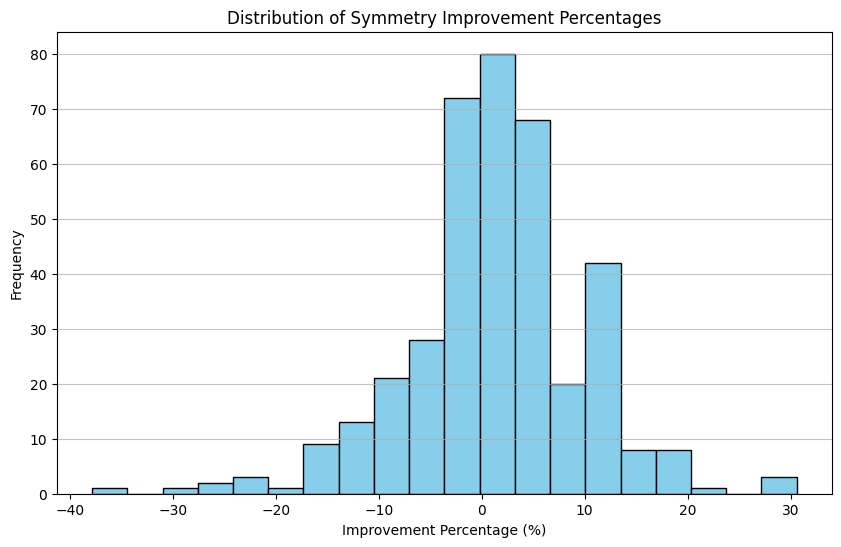

In [50]:

def calculate_percentage_improvement(before_score, after_score):
    if before_score == "FACE UNDETECTED" or after_score == "FACE UNDETECTED":
        return None
    return ((after_score - before_score) / before_score) * 100

# Apply the function to calculate improvements
new_df_with_symmetry['Improvement_Percentage'] = new_df_with_symmetry.apply(
    lambda row: calculate_percentage_improvement(row['Before_Symmetry_Score'], row['After_Symmetry_Score']), axis=1
)

# Drop rows with None values in Improvement_Percentage
improvement_data = new_df_with_symmetry['Improvement_Percentage'].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(improvement_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Symmetry Improvement Percentages')
plt.xlabel('Improvement Percentage (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [51]:
new_df_with_symmetry

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,before_bounding_box,after_bounding_box,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score,Symmetry_Improvement(in %),Improvement_Percentage
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,"(0, 0, 220, 329)","(0, 0, 220, 329)",Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161,2.165518,2.165518
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,"(0, 0, 220, 330)","(0, 0, 220, 330)",Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723,NO IMPROVEMENT,-9.113346
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,"(0, 0, 220, 140)","(0, 0, 220, 140)",Pair 3,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,"(0, 0, 220, 221)","(0, 0, 220, 221)",Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)",FACE UNDETECTED,39.606505,NO IMPROVEMENT,NaN
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,"(0, 0, 212, 347)","(0, 0, 212, 337)",Pair 5,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,before-898.jpg,after-898.jpg,"Timothy Rankin, MD","Greenbrae, CA",Treatment performed: Rhinoplasty\r\nDescriptio...,48912,before-898.jpg,after-898.jpg,[1.86862492e-01 2.69528601e-03 1.29247989e-03 ...,[1.85851210e-01 5.51373128e-03 7.11248433e-04 ...,"(0, 0, 182, 212)","(6, 0, 158, 212)",Pair 898,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN
898,before-899.jpg,after-899.jpg,"Rachel Ruotolo, MD","Garden City, NY",Rhinoplasty. Pre-op and 1 year post-op,37812,before-899.jpg,after-899.jpg,[ 2.33296616e-01 2.14963887e-02 3.64173476e-...,[ 2.02826418e-01 8.83091933e-03 4.26922298e-...,"(75, 0, 145, 178)","(89, 17, 131, 160)",Pair 899,"(0, 0, 35, 67)","(0, 0, 34, 65)",FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,"(0, 0, 220, 268)","(0, 0, 220, 268)",Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)",55.507335,55.048443,NO IMPROVEMENT,-0.826723
900,before-901.jpg,after-901.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-901.jpg,after-901.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,"(0, 0, 220, 206)","(63, 23, 157, 183)",Pair 901,"(0, 0, 42, 91)","(0, 0, 39, 89)",32.82343,34.531429,5.203598,5.203598


In [52]:
def export_with_symmetry_scores_to_csv(df, csv_filename):
    """
    Exports the given DataFrame to a CSV file with the specified filename.

    Parameters:
    - df: The DataFrame to export.
    - csv_filename: The name of the CSV file to create.
    """
    df.to_csv(f'../data/{csv_filename}', index=False)

In [53]:
export_with_symmetry_scores_to_csv(new_df_with_symmetry, 'concatenated_data_with_symmetry_scores_percentages_v3.csv')

### Facial Proportions and Ratios analysis

### Facial Proportions and Ratios Analysis in Rhinoplasty Surgery Outcome Assessment

In the context of assessing rhinoplasty surgery outcomes, analyzing facial proportions and ratios is crucial. This involves calculating specific measurements and comparing them to ideal proportions, such as the golden ratio, to evaluate the aesthetic results of the surgery. Below are two functions that facilitate this analysis:

#### `calculate_facial_proportions(landmarks)`

This function calculates key facial proportions and ratios using facial landmarks detected on an image. The measurements include:

- **Nose Length:** Calculated using landmarks 28 to 30.
- **Face Length:** Calculated using landmarks 1 to 9.
- **Nose Width:** Calculated using landmarks 31 to 35.
- **Face Width:** Calculated using landmarks 1 to 17.

The function then computes the following ratios:

- **Nose to Face Ratio:** The ratio of nose length to face length.
- **Nose Width to Face Width Ratio:** The ratio of nose width to face width.

Additionally, it calculates the deviation from the golden ratio (approximately 1.618), which is often considered an ideal aesthetic proportion.

#### `process_image_with_proportions(image_path)`

This function processes an image to detect facial landmarks and calculate the facial proportions using the `calculate_facial_proportions` function. It performs the following steps:

1. **Image Loading and Grayscale Conversion:** The image is loaded and converted to grayscale for facial landmark detection.
2. **Face Detection:** The function uses a face detector to identify faces in the image.
3. **Landmark Detection:** For each detected face, it extracts facial landmarks.
4. **Proportion Calculation:** It calculates the facial proportions and ratios using the detected landmarks.

If no face is detected in the image, the program returns `None` and prints a message indicating the absence of a detectable face.

In [54]:
def calculate_facial_proportions(landmarks):
    # Calculate nose length (landmarks 28–30)
    nose_length = np.linalg.norm(np.array([landmarks.part(28).x, landmarks.part(28).y]) - 
                                 np.array([landmarks.part(30).x, landmarks.part(30).y]))
    
    # Calculate face length (landmarks 1–9)
    face_length = np.linalg.norm(np.array([landmarks.part(1).x, landmarks.part(1).y]) - 
                                 np.array([landmarks.part(9).x, landmarks.part(9).y]))
    
    # Calculate nose width (landmarks 31–35)
    nose_width = np.linalg.norm(np.array([landmarks.part(31).x, landmarks.part(31).y]) - 
                                np.array([landmarks.part(35).x, landmarks.part(35).y]))
    
    # Calculate face width (landmarks 1–17)
    face_width = np.linalg.norm(np.array([landmarks.part(1).x, landmarks.part(1).y]) - 
                                np.array([landmarks.part(17).x, landmarks.part(17).y]))
    
    # Calculate ratios
    nose_to_face_ratio = nose_length / face_length
    nose_width_to_face_width = nose_width / face_width
    
    # Calculate deviation from the golden ratio
    GOLDEN_RATIO_CONST = 1.618
    deviation_from_GOLDEN_RATIO_CONST = abs(nose_width_to_face_width - GOLDEN_RATIO_CONST)
    
    return nose_to_face_ratio, nose_width_to_face_width, deviation_from_GOLDEN_RATIO_CONST

In [55]:
def process_image_with_proportions(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    
    if len(faces) == 0:
        print(f"No face detected in {image_path}")
        return None, None, None
    
    for face in faces:
        landmarks = predictor(gray, face)
        return calculate_facial_proportions(landmarks)

In [56]:
def process_all_images_with_proportions(df, image_folder):
    nose_to_face_ratios = []
    nose_width_to_face_widths = []
    deviations_from_golden_ratio = []
    
    for index, row in df.iterrows():
        before_image_path = os.path.join(image_folder, row['before_image'])
        after_image_path = os.path.join(image_folder, row['after_image'])
        
        before_ratios = process_image_with_proportions(before_image_path)
        after_ratios = process_image_with_proportions(after_image_path)
        
        if before_ratios and after_ratios:
            nose_to_face_ratios.append((before_ratios[0], after_ratios[0]))
            nose_width_to_face_widths.append((before_ratios[1], after_ratios[1]))
            deviations_from_golden_ratio.append((before_ratios[2], after_ratios[2]))
        else:
            nose_to_face_ratios.append((None, None))
            nose_width_to_face_widths.append((None, None))
            deviations_from_golden_ratio.append((None, None))
    
    df['Nose_to_Face_Ratio'] = nose_to_face_ratios
    df['Nose_Width_to_Face_Width'] = nose_width_to_face_widths
    df['Deviation_from_Golden_Ratio'] = deviations_from_golden_ratio

process_all_images_with_proportions(new_df_with_symmetry, image_folder)

No face detected in ../data_mining/rhinoplasty_images/before-3.jpg
No face detected in ../data_mining/rhinoplasty_images/after-3.jpg
No face detected in ../data_mining/rhinoplasty_images/before-4.jpg
No face detected in ../data_mining/rhinoplasty_images/before-5.jpg
No face detected in ../data_mining/rhinoplasty_images/after-5.jpg
No face detected in ../data_mining/rhinoplasty_images/before-6.jpg
No face detected in ../data_mining/rhinoplasty_images/after-6.jpg
No face detected in ../data_mining/rhinoplasty_images/before-8.jpg
No face detected in ../data_mining/rhinoplasty_images/before-9.jpg
No face detected in ../data_mining/rhinoplasty_images/after-9.jpg
No face detected in ../data_mining/rhinoplasty_images/before-11.jpg
No face detected in ../data_mining/rhinoplasty_images/after-11.jpg
No face detected in ../data_mining/rhinoplasty_images/before-13.jpg
No face detected in ../data_mining/rhinoplasty_images/after-13.jpg
No face detected in ../data_mining/rhinoplasty_images/before-15.

In [57]:
new_df_with_symmetry

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,...,Image Pair,Before Nose Bounding Box,After Nose Bounding Box,Before_Symmetry_Score,After_Symmetry_Score,Symmetry_Improvement(in %),Improvement_Percentage,Nose_to_Face_Ratio,Nose_Width_to_Face_Width,Deviation_from_Golden_Ratio
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,...,Pair 1,"(0, 0, 36, 111)","(0, 0, 38, 114)",59.010283,60.288161,2.165518,2.165518,"(0.22733947804527563, 0.2167578955163553)","(1.0181541784201853, 0.8195240165304088)","(0.5998458215798148, 0.7984759834695913)"
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,...,Pair 2,"(0, 0, 43, 113)","(0, 0, 45, 112)",43.798763,39.80723,NO IMPROVEMENT,-9.113346,"(0.2451132805151894, 0.24216305891542286)","(0.7660323462854265, 0.7215773092122456)","(0.8519676537145736, 0.8964226907877545)"
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,...,Pair 3,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN,"(None, None)","(None, None)","(None, None)"
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,...,Pair 4,"(0, 0, 56, 101)","(0, 0, 47, 94)",FACE UNDETECTED,39.606505,NO IMPROVEMENT,NaN,"(None, 0.26614235073459946)","(None, 0.6124932073044426)","(None, 1.0055067926955576)"
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,...,Pair 5,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN,"(None, None)","(None, None)","(None, None)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,before-898.jpg,after-898.jpg,"Timothy Rankin, MD","Greenbrae, CA",Treatment performed: Rhinoplasty\r\nDescriptio...,48912,before-898.jpg,after-898.jpg,[1.86862492e-01 2.69528601e-03 1.29247989e-03 ...,[1.85851210e-01 5.51373128e-03 7.11248433e-04 ...,...,Pair 898,NaN,NaN,FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN,"(None, None)","(None, None)","(None, None)"
898,before-899.jpg,after-899.jpg,"Rachel Ruotolo, MD","Garden City, NY",Rhinoplasty. Pre-op and 1 year post-op,37812,before-899.jpg,after-899.jpg,[ 2.33296616e-01 2.14963887e-02 3.64173476e-...,[ 2.02826418e-01 8.83091933e-03 4.26922298e-...,...,Pair 899,"(0, 0, 35, 67)","(0, 0, 34, 65)",FACE UNDETECTED,FACE UNDETECTED,NO IMPROVEMENT,NaN,"(None, None)","(None, None)","(None, None)"
899,before-900.jpg,after-900.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",A young man is shown 6 weeks after a Septoplas...,37717,before-900.jpg,after-900.jpg,[2.01228165e-01 4.50386827e-03 3.00683623e-04 ...,[ 1.69701902e-01 5.46172557e-05 3.34493044e-...,...,Pair 900,"(0, 0, 38, 111)","(0, 0, 38, 112)",55.507335,55.048443,NO IMPROVEMENT,-0.826723,"(0.23439646061933167, 0.22726857836359474)","(0.7321402951379646, 0.8702076825611124)","(0.8858597048620355, 0.7477923174388877)"
900,before-901.jpg,after-901.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 20s, 3 weeks post-op rhinoplast...",36311,before-901.jpg,after-901.jpg,[ 1.81957832e-01 2.55163590e-03 1.00738516e-...,[ 1.90736389e-01 5.25719919e-03 4.43487166e-...,...,Pair 901,"(0,

### Face Ratio Interpretation:

When comparing facial proportions to the **Golden Ratio**, we can assess the aesthetic balance of the face by measuring specific ratios, such as:

- **Nose-to-Face Ratio**: The proportion of the nose length relative to the overall face length. If the actual ratio is close to the ideal Golden Ratio value, it indicates a balanced and aesthetically harmonious facial structure.
  
- **Nose-Width-to-Face-Width Ratio**: This ratio compares the width of the nose to the width of the face. Deviations from the ideal Golden Ratio can suggest a nose that is wider or narrower than ideal proportions.

- **Deviation from Golden Ratio**: This value shows how much the actual ratios deviate from the ideal Golden Ratio proportions. Smaller deviations indicate a closer alignment to the "ideal" Golden Ratio, often associated with balanced and appealing facial features.

Un exemple d'interpretation </br>
### Nose_to_Face_Ratio:
- **Actual ratio**: `0.2273` (this is the ratio of the nose length to the overall face length).
- **Golden Ratio equivalent**: `0.2168` (the "ideal" proportion based on the Golden Ratio).
- **Interpretation**: Your nose-to-face ratio is slightly larger than the idealized ratio. In this case, the difference is small, so it would still be considered aesthetically harmonious.

### Nose_Width_to_Face_Width:
- **Actual ratio**: `1.0182` (this is the ratio of the nose width to the face width).
- **Golden Ratio equivalent**: `0.8195`.
- **Interpretation**: Your nose width is slightly wider compared to the idealized Golden Ratio. A ratio above 1 means that the nose width is slightly greater than the ideal nose width compared to face width.

### Deviation_from_Golden_Ratio:
- **Actual deviation**: `0.5998`.
- **Golden Ratio equivalent deviation**: `0.7985`.
- **Interpretation**: This deviation measures how far the actual ratios deviate from the Golden Ratio proportions. The deviation suggests that the actual facial proportions differ by around `0.60` from the ideal Golden Ratio proportions, and the ideal deviation would be closer to `0.80`.


In [58]:
def calculate_angle(point1, point2, point3):
    """Calculate the angle between three points."""
    a = np.array(point1)
    b = np.array(point2)
    c = np.array(point3)

    ab = b - a
    cb = b - c

    angle = atan2(cb[1], cb[0]) - atan2(ab[1], ab[0])
    return abs(degrees(angle))

def measure_angles(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    for face in faces:
        # Get the landmarks
        landmarks = predictor(gray, face)

        # Define points for nasolabial angle
        nose_tip = (landmarks.part(33).x, landmarks.part(33).y)
        upper_lip = (landmarks.part(51).x, landmarks.part(51).y)
        chin = (landmarks.part(8).x, landmarks.part(8).y)

        # Define points for nasal bridge angle
        nose_bridge = (landmarks.part(27).x, landmarks.part(27).y)
        forehead = (landmarks.part(19).x, landmarks.part(19).y)

        # Calculate angles
        nasolabial_angle = calculate_angle(upper_lip, nose_tip, chin)
        nasal_bridge_angle = calculate_angle(forehead, nose_bridge, nose_tip)

        print(f"Nasolabial Angle: {nasolabial_angle:.2f} degrees")
        print(f"Nasal Bridge Angle: {nasal_bridge_angle:.2f} degrees")

# Example usage
before_img_path = '../data_mining/rhinoplasty_images/before-1.jpg'
after_img_path = '../data_mining/rhinoplasty_images/after-1.jpg'

print("Before Surgery:")
measure_angles(before_img_path)

print("\nAfter Surgery:")
measure_angles(after_img_path)

Before Surgery:
Nasolabial Angle: 3.46 degrees
Nasal Bridge Angle: 116.00 degrees

After Surgery:
Nasolabial Angle: 2.15 degrees
Nasal Bridge Angle: 115.88 degrees


Before Surgery:
Nasolabial Angle: 3.46 degrees
Nasal Bridge Angle: 116.00 degrees


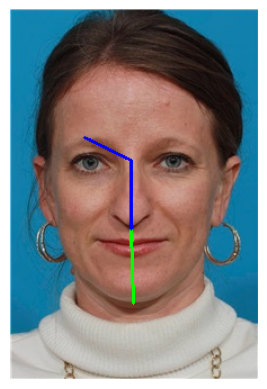


After Surgery:
Nasolabial Angle: 2.15 degrees
Nasal Bridge Angle: 115.88 degrees


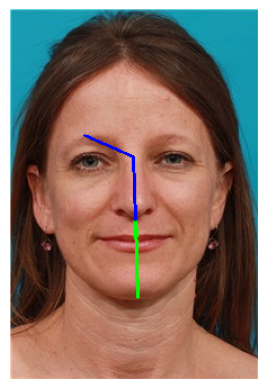

In [6]:
def measure_and_visualize_angles(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    for face in faces:
        # Get the landmarks
        landmarks = predictor(gray, face)

        # Define points for nasolabial angle
        nose_tip = (landmarks.part(33).x, landmarks.part(33).y)
        upper_lip = (landmarks.part(51).x, landmarks.part(51).y)
        chin = (landmarks.part(8).x, landmarks.part(8).y)

        # Define points for nasal bridge angle
        nose_bridge = (landmarks.part(27).x, landmarks.part(27).y)
        forehead = (landmarks.part(19).x, landmarks.part(19).y)

        # Calculate angles
        nasolabial_angle = calculate_angle(upper_lip, nose_tip, chin)
        nasal_bridge_angle = calculate_angle(forehead, nose_bridge, nose_tip)

        print(f"Nasolabial Angle: {nasolabial_angle:.2f} degrees")
        print(f"Nasal Bridge Angle: {nasal_bridge_angle:.2f} degrees")

        # Draw lines for visualization
        cv2.line(image, upper_lip, nose_tip, (0, 255, 0), 2)
        cv2.line(image, nose_tip, chin, (0, 255, 0), 2)
        cv2.line(image, forehead, nose_bridge, (255, 0, 0), 2)
        cv2.line(image, nose_bridge, nose_tip, (255, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Example usage
print("Before Surgery:")
measure_and_visualize_angles('../data_mining/rhinoplasty_images/before-1.jpg')

print("\nAfter Surgery:")
measure_and_visualize_angles('../data_mining/rhinoplasty_images/after-1.jpg')

Before Surgery:
Nasolabial Angle: 9.88 degrees
Nasal Bridge Angle: 126.17 degrees


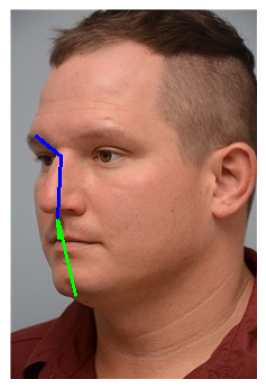


After Surgery:
Nasolabial Angle: 12.55 degrees
Nasal Bridge Angle: 126.75 degrees


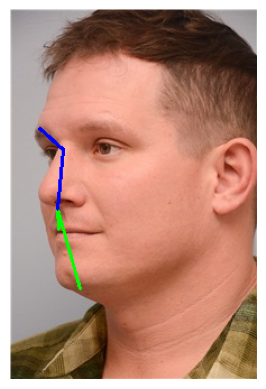

In [59]:
print("Before Surgery:")
measure_and_visualize_angles('../data_mining/rhinoplasty_images/before-2.jpg')

print("\nAfter Surgery:")
measure_and_visualize_angles('../data_mining/rhinoplasty_images/after-2.jpg')

Before Surgery:
Nasolabial Angle: 3.12 degrees
Nasal Bridge Angle: 120.01 degrees


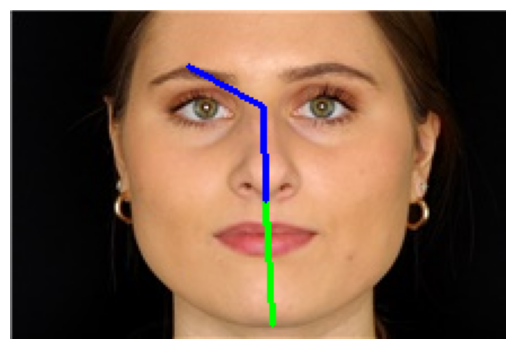


After Surgery:
Nasolabial Angle: 2.16 degrees
Nasal Bridge Angle: 123.08 degrees


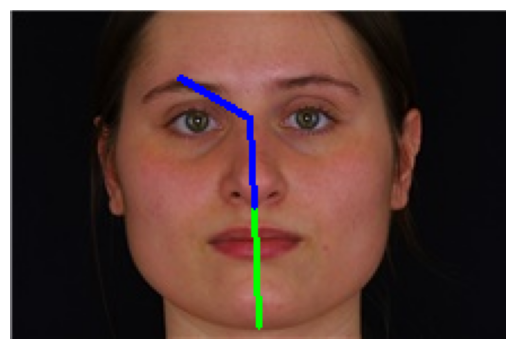

In [60]:
print("Before Surgery:")
measure_and_visualize_angles('../data_mining/rhinoplasty_images/before-10.jpg')

print("\nAfter Surgery:")
measure_and_visualize_angles('../data_mining/rhinoplasty_images/after-10.jpg')

In [64]:
def calculate_angle(point1, point2, point3):
    """Calculate the angle between three points."""
    a = np.array(point1)
    b = np.array(point2)
    c = np.array(point3)
    ab = b - a
    cb = b - c
    angle = atan2(cb[1], cb[0]) - atan2(ab[1], ab[0])
    return abs(degrees(angle))

def measure_angles(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = detector(gray)

    for face in faces:
        # Get the landmarks
        landmarks = predictor(gray, face)

        # Define points for nasolabial angle
        nose_tip = (landmarks.part(33).x, landmarks.part(33).y)
        upper_lip = (landmarks.part(51).x, landmarks.part(51).y)
        chin = (landmarks.part(8).x, landmarks.part(8).y)

        # Define points for nasal bridge angle
        nose_bridge = (landmarks.part(27).x, landmarks.part(27).y)
        forehead = (landmarks.part(19).x, landmarks.part(19).y)

        # Calculate angles
        nasolabial_angle = calculate_angle(upper_lip, nose_tip, chin)
        nasal_bridge_angle = calculate_angle(forehead, nose_bridge, nose_tip)

        return nasolabial_angle, nasal_bridge_angle

    return None, None

# Process all image pairs and store results
angle_data = []

for i in range(1, 15):
    before_img_path = f"../data_mining/rhinoplasty_images/before-{i}.jpg"
    after_img_path = f"../data_mining/rhinoplasty_images/after-{i}.jpg"

    nasolabial_angle_before, nasal_bridge_angle_before = measure_angles(before_img_path)
    nasolabial_angle_after, nasal_bridge_angle_after = measure_angles(after_img_path)

    angle_data.append({
        "NasolabialAngleBefore": nasolabial_angle_before,
        "NasalBridgeAngleBefore": nasal_bridge_angle_before,
        "NasolabialAngleAfter": nasolabial_angle_after,
        "NasalBridgeAngleAfter": nasal_bridge_angle_after
    })

# Create a DataFrame from the angle data
angles_df = pd.DataFrame(angle_data)

# Merge with the existing DataFrame
new_df_with_symmetry = pd.concat([new_df_with_symmetry, angles_df], axis=1)

In [66]:
new_df_with_symmetry.head(10)

,PictureOfBefore,PictureOfAfter,SurgeonInfo,Location,Description,CaseNumber,before_image,after_image,before_hu_moments,after_hu_moments,...,Nose_Width_to_Face_Width,Deviation_from_Golden_Ratio,NasolabialAngleBefore,NasalBridgeAngleBefore,NasolabialAngleAfter,NasalBridgeAngleAfter,NasolabialAngleBefore,NasalBridgeAngleBefore,NasolabialAngleAfter,NasalBridgeAngleAfter
0,before-1.jpg,after-1.jpg,"Michael Bogdan, MD, MBA, FACS","Grapevine, TX",Open Rhinoplasty,31976,before-1.jpg,after-1.jpg,[2.63778557e-01 2.00879315e-02 2.58652824e-03 ...,[ 2.72267271e-01 1.83745415e-02 4.15011177e-...,...,"(1.0181541784201853, 0.8195240165304088)","(0.5998458215798148, 0.7984759834695913)",3.458724,116.003346,2.153792,115.884149,3.458724,116.003346,2.153792,115.884149
1,before-2.jpg,after-2.jpg,"Carlos Rivera-Serrano, MD","Miami Beach, FL",No description available,43745,before-2.jpg,after-2.jpg,[1.99866889e-01 3.59444342e-03 1.94506877e-05 ...,[1.92935516e-01 4.46351105e-03 7.49286087e-07 ...,...,"(0.7660323462854265, 0.7215773092122456)","(0.8519676537145736, 0.8964226907877545)",9.875417,126.167276,12.552175,126.748283,9.875417,126.167276,12.552175,126.748283
2,before-3.jpg,after-3.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48893,before-3.jpg,after-3.jpg,[ 1.87282133e-01 5.65354910e-03 8.56384980e-...,[ 2.37052200e-01 2.84002266e-02 1.39636769e-...,...,"(None, None)","(None, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,before-4.jpg,after-4.jpg,"Richard Reish, MD, FACS","New York, NY","A woman in her 50s, two months post-op revisio...",45298,before-4.jpg,after-4.jpg,[1.68974686e-01 2.94395365e-04 3.76222494e-04 ...,[ 1.93967513e-01 1.28468030e-03 2.00448948e-...,...,"(None, 0.6124932073044426)","(None, 1.0055067926955576)",NaN,NaN,3.887200,130.702613,NaN,NaN,3.887200,130.702613
4,before-5.jpg,after-5.jpg,"Neal Goldberg, MD","Scarsdale, NY",Closed rhinoplasty for dorsal hump,22555,before-5.jpg,after-5.jpg,[1.99412133e-01 8.76585978e-03 1.53562763e-03 ...,[2.46264712e-01 5.03881580e-03 2.10117282e-03 ...,...,"(None, None)","(None, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,before-6.jpg,after-6.jpg,"Michelle Copeland, MD, DMD, FACS, PC","New York, NY",No description available,25849,before-6.jpg,after-6.jpg,[ 2.07426779e-01 1.47807566e-03 5.24644822e-...,[ 2.10700470e-01 1.32814761e-02 1.62098783e-...,...,"(None, None)","(None, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,before-7.jpg,after-7.jpg,"Jerry Weiger Chang, MD, FACS","Flushing, NY",35 year old male complains of large dorsal hum...,41844,before-7.jpg,after-7.jpg,[ 1.84730300e-01 6.22724431e-03 6.86225971e-...,[ 1.84017721e-01 6.53500620e-03 2.54376089e-...,...,"(0.8689266695452383, 0.9593655015712707)","(0.7490733304547618, 0.6586344984287295)",0.000000,121.323499,3.094058,119.248826,0.000000,121.323499,3.094058,119.248826
7,before-8.jpg,after-8.jpg,"Adam Weinfeld, MD","Austin, TX",Rhinoplasty,44629,before-8.jpg,after-8.jpg,[ 1.77365033e-01 2.21953081e-03 1.10030853e-...,[ 1.78842601e-01 1.91760989e-03 1.95815479e-...,...,"(None, 0.34164198059109807)","(None, 1.2763580194089021)",NaN,NaN,13.591394,139.312240,NaN,NaN,13.591394,139.312240
8,before-9.jpg,after-9.jpg,"Mark Markarian, MD, MSPH, FACS","Wellesley, MA",Immediate postop results are shown in this pat...,48550,before-9.jpg,after-9.jpg,[ 2.50943690e-01 2.15910491e-02 2.90325627e-...,[2.44036296e-01 2.76795590e-02 1.69182477e-03 ...,...,"(None, None)","(None, None)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,before-10.jpg,after-10.jpg,"Landon Pryor, MD, FACS","Rockford, IL",21 year old female treated with rhinoplasty. P...,45032,before-10.jpg,after-10.jpg,[ 1.63428818e-01 5.54170488e-04 5.41057282e-...,[ 2.20407975e-01 4.87431585e-03 2.01122297e-...,...,"(0.6845804349707488, 0.6640783086353597)","(0.9334195650292513, 0.9539216913646404)",3.122130,120.007641,2.161079,123.077059,3.122130,120.007641,2.161079,123.077059


In [67]:
export_with_symmetry_scores_to_csv(new_df_with_symmetry, 'concatenated_data_with_symmetry_and_angles_ratios_v4.csv')